## Use bedtools subtract to remove the predicted polyA regions from oligo file

In [ ]:
sort -k1,1 -k2,2n haplo.lib.hg19.bed > haplo.sorted.bed
sort -k1,1 -k2,2n hg19.polyadb.bed > polya.sorted.bed
sort -k1,1 -k2,2n hg19.polya.seq.brain.bed > polya.seq.brain.sorted.bed
sort -k1,1 -k2,2n hg19.polya.seq.kidney.bed > polya.seq.kidney.sorted.bed
sort -k1,1 -k2,2n hg19.polya.seq.maqcbrain.bed > polya.seq.maqcbrain.sorted.bed
sort -k1,1 -k2,2n hg19.polya.seq.maqcbrain2.bed > polya.seq.maqcbrain2.sorted.bed
sort -k1,1 -k2,2n hg19.polya.seq.brainRv.bed > polya.seq.brainRv.sorted.bed

bedtools intersect -a haplo.sorted.bed -b polya.sorted.bed -v > haplo_no_overlap.bed
bedtools intersect -a haplo_no_overlap.bed -b polya.seq.brain.sorted.bed -v > haplo_no_overlap1.bed
bedtools intersect -a haplo_no_overlap1.bed -b polya.seq.brain.sorted.bed -v > haplo_no_overlap2.bed
bedtools intersect -a haplo_no_overlap2.bed -b polya.seq.maqcbrain.sorted.bed -v > haplo_no_overlap3.bed
bedtools intersect -a haplo_no_overlap3.bed -b polya.seq.maqcbrain2.sorted.bed -v > haplo_no_overlap4.bed
bedtools intersect -a haplo_no_overlap4.bed -b polya.seq.brainRv.sorted.bed -v > haplo_no_overlap5.bed





## Match the bed file with filtered_sk/hek_df100.csv file

In [2]:
import pandas as pd

# Load BED file into a DataFrame
bed_columns = ["chrom", "start", "end", "name", "score", "strand"]
bed_df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/polya_analysis/haplo_no_overlap5.bed", sep="\t", names=bed_columns)

# Load CSV file into a DataFrame
csv_df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/fitered_no_polyA_hek.csv")
# csv_df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/fitered_no_polyA_sk.csv")

# Merge on the "name" column in BED and the first column in CSV
merged_df = bed_df.merge(csv_df, left_on="name", right_on=csv_df.columns[0], how="inner")

# Save merged data to a new CSV file
merged_df.to_csv("no_polyA_hek.csv", index=False)
# merged_df.to_csv("no_polyA_sk.csv", index=False)

print(len(merged_df))

5401


## Draw a scatter plot

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.colors as mcolors

# Load data
counts_hek = pd.read_csv('/home/yg2895/media/protein/yg2895/ASO-lib-20250102/polya_analysis/no_polyA_hek.csv') 
counts_sk = pd.read_csv('/home/yg2895/media/protein/yg2895/ASO-lib-20250102/polya_analysis/no_polyA_sk.csv') 

# Merge data on a common column (e.g., "gene" if available)
df = pd.merge(counts_hek, counts_sk, on="Name", suffixes=("_hek", "_sk"))

# Create DataFrame with required columns
df = df[['Name','log2FoldChange_hek', 'log2FoldChange_sk', 'padj_hek', 'padj_sk']].copy()
df.rename(columns={'log2FoldChange_hek': 'HEK log2FC', 'log2FoldChange_sk': 'SK log2FC', 
                   'padj_hek': 'p_value_hek', 'padj_sk': 'p_value_sk'}, inplace=True)

# Handle p-values (e.g., take the minimum of both cell lines)
df['p_value'] = df[['p_value_hek', 'p_value_sk']].min(axis=1)
df['p_value'] = df['p_value'].replace(0, 1e-300)  # Prevent log(0) error
df['log10_pvalue'] = -np.log10(df['p_value'])  # Convert to log scale

# Compute Pearson correlation
df_clean = df.dropna(subset=['HEK log2FC', 'SK log2FC'])  # Ensure no NaN values
corr, pval = pearsonr(df_clean['HEK log2FC'], df_clean['SK log2FC'])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3e}")

Pearson correlation: 0.825, p-value: 0.000e+00


                              Name  HEK log2FC  SK log2FC  log10_pvalue
13        DFFB|ENST00000378209.8|1    1.890018   6.544369    282.071625
1363    MEIS2|ENST00000561208.6|12    0.406996   6.421712    110.610512
3863   ARID1B|ENST00000636930.2|13    0.981550   6.301700    203.881206
5123     XIAP|ENST00000371199.8|13    0.580184   6.124521    113.554481
1883   TGIF1|ENST00000343820.10|15    0.146369   5.639006    137.460738
5366     SHOX|ENST00000686671.1|47    0.236173   5.570879    142.233628
543       BUB3|ENST00000368865.9|8   -0.600949   5.274009    115.738779
3437  SEMA5A|ENST00000382496.10|45    1.245676   5.265341    146.878424
4412     ANOS1|ENST00000262648.8|5   -0.426822   4.835375     78.190334
2470   BMPR2|ENST00000374580.10|48    0.366597   4.741734     89.051845
3322   SH3BP2|ENST00000503393.8|48   -0.820388   4.464893     77.243879
3661   SH3TC2|ENST00000515425.6|23    1.390499   4.433075     62.606746
239       LMNA|ENST00000368300.9|6    1.166170   4.181035     53

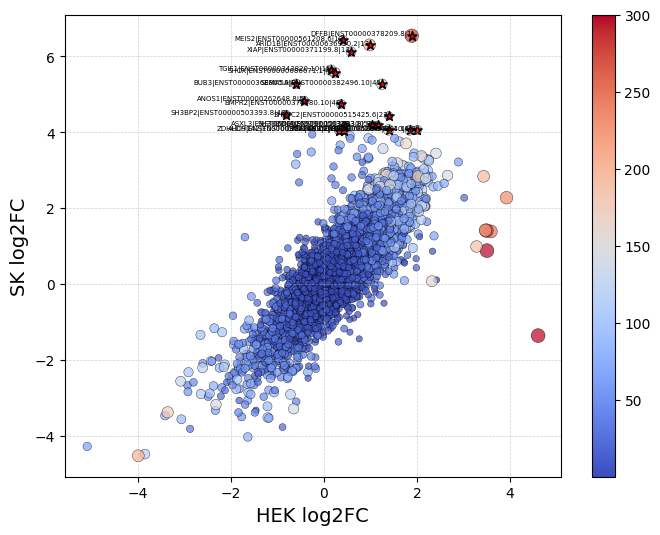

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Identify top 3 points with highest absolute log2FC values in either cell line
top1_smallest = df_clean.nlargest(20, 'SK log2FC')

# Print Name and log2FC values
print(top1_smallest[['Name', 'HEK log2FC', 'SK log2FC', 'log10_pvalue']])

plt.figure(figsize=(8, 6))

# Scatter plot
scatter = sns.scatterplot(
    x='HEK log2FC', 
    y='SK log2FC', 
    hue='log10_pvalue',  
    size='log10_pvalue',  
    sizes=(20, 100),  
    palette='coolwarm',  
    data=df_clean, 
    edgecolor='black',  
    alpha=0.7,  
    legend=False
)

# # Highlight and annotate top 3 points with their names
for i, row in top1_smallest.iterrows():
    plt.scatter(row['HEK log2FC'], row['SK log2FC'], color='red', edgecolor='black', s=50, marker='*')
    plt.text(row['HEK log2FC'], row['SK log2FC'], row['Name'], fontsize=5, ha='right', color='black')

# Create ScalarMappable for color bar
norm = mcolors.Normalize(vmin=df_clean['log10_pvalue'].min(), vmax=df_clean['log10_pvalue'].max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Get current axis and create color bar
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('-log10(p-value)')
plt.xlabel('HEK log2FC', fontsize=14)
plt.ylabel('SK log2FC', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.show()